# 2018-11-15 A very simple recurrent ring network
L'idée est de faire un petit ring tout simple qui assemble différentes cellules simples de V1 pour jouer avec ses dynamiques et pourquoi pas lui faire apprendre une tuning curve d'entrée

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from LogGabor import LogGabor
import Spiking_LGN as SpiLGN
import datetime
from tqdm import tqdm

In [2]:
load_npz = np.load('./output/Use_this_one.npz') #what a great, descriptive filename
load_arr = load_npz['arr_0.npy']

In [3]:
load_arr.shape

test_arr = load_arr.copy()
test_arr = test_arr.swapaxes(0,1)

print('Swapped array shape', test_arr.shape)
total_neurons = test_arr.shape[0] * test_arr.shape[1]
print('Total V1 Ring Neurons :', total_neurons)

Swapped array shape (49, 12, 2)
Total V1 Ring Neurons : 588


In [4]:
import pyNN.nest as sim
from pyNN.random import RandomDistribution as rnd
from pyNN.parameters import Sequence
from pyNN.utility.plotting import Figure, Panel

##########
# Params #
##########
neuron_params = {'cm': .5, #nF - McCormick
                 'e_rev_E': 0.0, #mV - McCormick but default values
                 'e_rev_I': -70.0, #mV - McCormick but default values
                 'tau_m': 30, #ms - Markram
                 'tau_refrac': 1.5, #ms - McCormick
                 'tau_syn_E': 0.25, #ms -McCormick
                 'tau_syn_I': 0.75, #ms - McCormick
                 'v_reset': -56.5, #mV - McCormick
                 'v_rest': -73.6, #mV - McCormick
                 'v_thresh': -52.5 #mV - McCormick #mV - McCormick
                    }

gain = .1
injection_sampling_rate = 1
total_time = 1000

current_times = np.linspace(0,total_time,total_time/injection_sampling_rate)

sim.setup(timestep=0.1)
simple_cells = sim.Population(total_neurons, sim.IF_cond_alpha(**neuron_params),
                        initial_values={"v": neuron_params["v_reset"]}, label="simple_cells")

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


/home/hugo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


In [5]:
neuron_iterator = 0

with tqdm(total = total_neurons, desc = 'LGN is communicating with V1') as progress_bar :
    for positions in test_arr:
        for orientations in positions :
            #injecting all ON LGN current
            for inputs in orientations[0]:
                current_level = inputs[::injection_sampling_rate]
                current_level = np.asarray(current_level)

                current_input = sim.StepCurrentSource(times = current_times,
                                                 amplitudes = current_level*gain)
                current_input.inject_into(simple_cells[neuron_iterator:neuron_iterator+1])
                current_input.record()
                
            #injecting all OFF LGN current
            for inputs in orientations[1]:
                current_level = inputs[::injection_sampling_rate]
                current_level = np.asarray(current_level)

                current_input = sim.StepCurrentSource(times = current_times,
                                                 amplitudes = current_level*gain)
                current_input.inject_into(simple_cells[neuron_iterator:neuron_iterator+1])
                current_input.record()
                
            #moving on to next V1 neuron 
            neuron_iterator +=1
            progress_bar.update(1)

LGN is communicating with V1: 100%|██████████| 588/588 [00:17<00:00, 33.77it/s]


In [6]:
simple_cells.record(['spikes', 'v'])
sim.run(total_time)
sim.end()

In [7]:
v1_data = simple_cells.get_data().segments[0]
v1_voltage = v1_data.analogsignals[0]

# Simulation is done
Now we have N neurons and we have looped through positions then orientations, so we have :

In [8]:
test_arr.shape[0]

49

groups of positions, each of which contains

In [9]:
test_arr.shape[1]

12

neurons, each one sensitive for a particular orientation. We double check that the total is N :

In [10]:
test_arr.shape[0] * test_arr.shape[1]

588

# Plotting
Now we can plot one single positions and check its orientation informations :

In [11]:
np.asarray(v1_data.spiketrains[3]).shape

(0,)

In [12]:
v1_data.spiketrains[49]

<SpikeTrain(array([], dtype=float64) * ms, [0.0 ms, 1000.0 ms])>

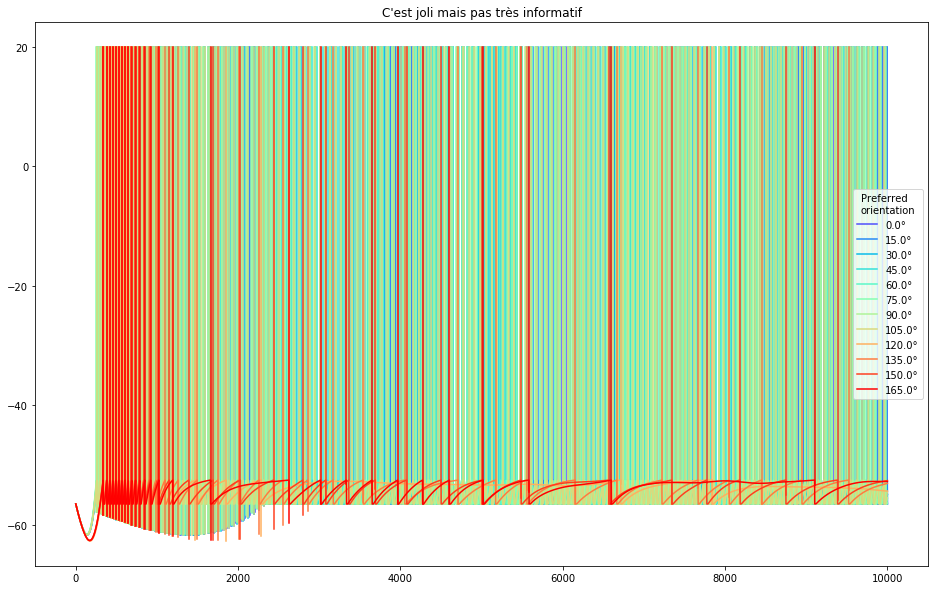

In [13]:
#NEO's arrays are weirdly shaped, we have to transpose them
fig, ax = plt.subplots(figsize = (16,10))
colors = plt.cm.rainbow(np.linspace(.1, 1, test_arr.shape[1]))

neuron_iterator = 0
position = 4

for orientations in test_arr[position]:
    index = neuron_iterator + (position * test_arr.shape[0]) #we're skipping the other positions

    ax.plot(v1_voltage.T[index],
            color=colors[neuron_iterator],
            label='%.1f°' % (neuron_iterator*(np.pi/12)*180/np.pi),
            alpha = 1)
        
    for spikes in np.asarray(v1_data.spiketrains[index]):
        plt.plot([ spikes*10,spikes*10 ] , [v1_voltage.T[index][int(spikes)] , 20],
        color=colors[neuron_iterator])

    neuron_iterator +=1


plt.legend(title = 'Preferred\norientation')
plt.title("C'est joli mais pas très informatif")
plt.show()

# C'est pas très lisible, on peut faire un peu mieux avec un rasterplot

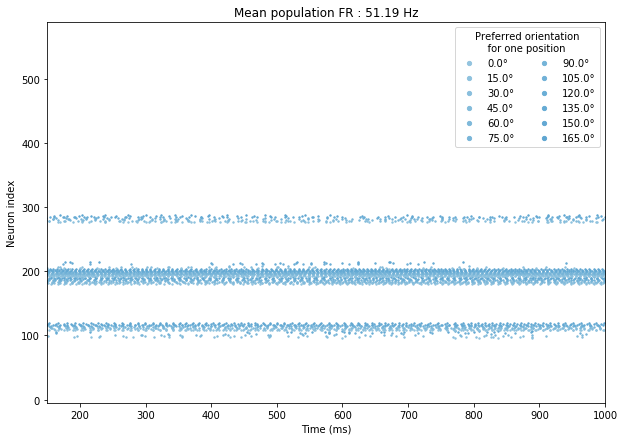

In [14]:
fig, ax = plt.subplots(figsize=(10, 7))

neuron_iterator = 0
total_spikes, total_spiking_neurons = 0, 0
for positions in test_arr:
    colors = plt.cm.Blues(np.linspace(.4, 1, test_arr.shape[0]))
    for i, orientations in enumerate(positions):
        ax.scatter(v1_data.spiketrains[neuron_iterator],
                   np.full_like(
                       v1_data.spiketrains[neuron_iterator], neuron_iterator),
                   s=2, color=colors[i],
                   label='%.1f°' % (i*(np.pi/12)*180/np.pi) if neuron_iterator < 12 else '')
        total_spikes += len(v1_data.spiketrains[neuron_iterator])
        if len(v1_data.spiketrains[neuron_iterator]) > 0:
            total_spiking_neurons += 1
        neuron_iterator += 1

plt.ylim(-5, total_neurons)
plt.xlim(150, total_time)
plt.ylabel('Neuron index')
plt.xlabel('Time (ms)')
handles, labels = ax.get_legend_handles_labels()
#handles[::-1], labels[::-1],
plt.legend(markerscale=3, title='Preferred orientation\n    for one position',
           ncol=2)

plt.title('''Mean population FR : %.2f Hz''' % (total_spikes/total_spiking_neurons))

plt.savefig('./figs/2018_11_16_Ring_spikes_nosynapses.pdf', format = 'pdf', dpi = 200, bbox_inches = 'tight')
            
plt.show()

In [15]:
print('Total spikes : ', total_spikes)
print('Total spiking neurons : ', total_spiking_neurons)
print('Mean population FR : %.2f Hz' % (total_spikes/total_spiking_neurons))

Total spikes :  6245
Total spiking neurons :  122
Mean population FR : 51.19 Hz


# C'est mieux mais on peut faire ça par orientation plutot que par position
Ca nous donnera un plus joli rasterplot et une meilleure information sur ce que le réseau représente en terme d'information orientée

In [16]:
test_arr = load_arr.copy()

print('Swapped array shape', test_arr.shape)
total_neurons = test_arr.shape[0] * test_arr.shape[1]
print('Total V1 Ring Neurons :', total_neurons)

Swapped array shape (12, 49, 2)
Total V1 Ring Neurons : 588


In [17]:
##########
# Params #
##########
neuron_params = {'cm': .5, #nF - McCormick
                 'e_rev_E': 0.0, #mV - McCormick but default values
                 'e_rev_I': -70.0, #mV - McCormick but default values
                 'tau_m': 30, #ms - Markram
                 'tau_refrac': 1.5, #ms - McCormick
                 'tau_syn_E': 0.25, #ms -McCormick
                 'tau_syn_I': 0.75, #ms - McCormick
                 'v_reset': -56.5, #mV - McCormick
                 'v_rest': -73.6, #mV - McCormick
                 'v_thresh': -52.5 #mV - McCormick #mV - McCormick
                    }

gain = .1
injection_sampling_rate = 1
total_time = 1000

current_times = np.linspace(0,total_time,total_time/injection_sampling_rate)

sim.setup(timestep=0.1)
simple_cells = sim.Population(total_neurons, sim.IF_cond_alpha(**neuron_params),
                        initial_values={"v": neuron_params["v_reset"]}, label="simple_cells")

neuron_iterator = 0

with tqdm(total = total_neurons, desc = 'LGN is communicating with V1') as progress_bar :
    for positions in test_arr: #WRONG VARIABLE NAME but it works the same nonetheless
        for orientations in positions :
            #injecting all ON LGN current
            for inputs in orientations[0]:
                current_level = inputs[::injection_sampling_rate]
                current_level = np.asarray(current_level)

                current_input = sim.StepCurrentSource(times = current_times,
                                                 amplitudes = current_level*gain)
                current_input.inject_into(simple_cells[neuron_iterator:neuron_iterator+1])
                current_input.record()
                
            #injecting all OFF LGN current
            for inputs in orientations[1]:
                current_level = inputs[::injection_sampling_rate]
                current_level = np.asarray(current_level)

                current_input = sim.StepCurrentSource(times = current_times,
                                                 amplitudes = current_level*gain)
                current_input.inject_into(simple_cells[neuron_iterator:neuron_iterator+1])
                current_input.record()
                
            #moving on to next V1 neuron 
            neuron_iterator +=1
            progress_bar.update(1)
            
simple_cells.record(['spikes', 'v'])
sim.run(total_time)
sim.end()

/home/hugo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
LGN is communicating with V1: 100%|██████████| 588/588 [00:16<00:00, 36.05it/s]


In [18]:
v1_data = simple_cells.get_data().segments[0]
v1_voltage = v1_data.analogsignals[0]

Same idea as before, we have

In [19]:
test_arr.shape[0]

12

orientations, and within 

In [20]:
test_arr.shape[1]

49

positions, for a total of 

In [21]:
test_arr.shape[0] * test_arr.shape[1]

588

neurons, so everything works once again. We know plot for orientations, not for positions

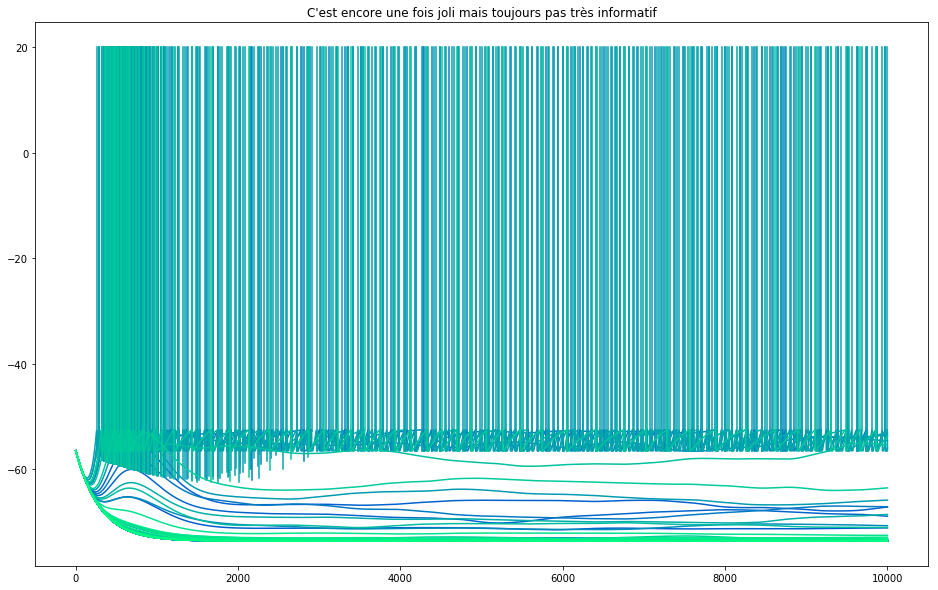

In [22]:
#NEO's arrays are weirdly shaped, we have to transpose them
fig, ax = plt.subplots(figsize = (16,10))
colors = plt.cm.winter(np.linspace(.1, 1, test_arr.shape[1]))

neuron_iterator = 0
orientation = 3

for positions in test_arr[orientation]:
    index = neuron_iterator + (orientation * test_arr.shape[0]) #we're skipping the other positions

    ax.plot(v1_voltage.T[index],
            color=colors[neuron_iterator],
            alpha = 1)
        
    for spikes in np.asarray(v1_data.spiketrains[index]):
        plt.plot([ spikes*10,spikes*10 ] , [v1_voltage.T[index][int(spikes)] , 20],
        color=colors[neuron_iterator])

    neuron_iterator +=1


plt.title("C'est encore une fois joli mais toujours pas très informatif")
plt.show()

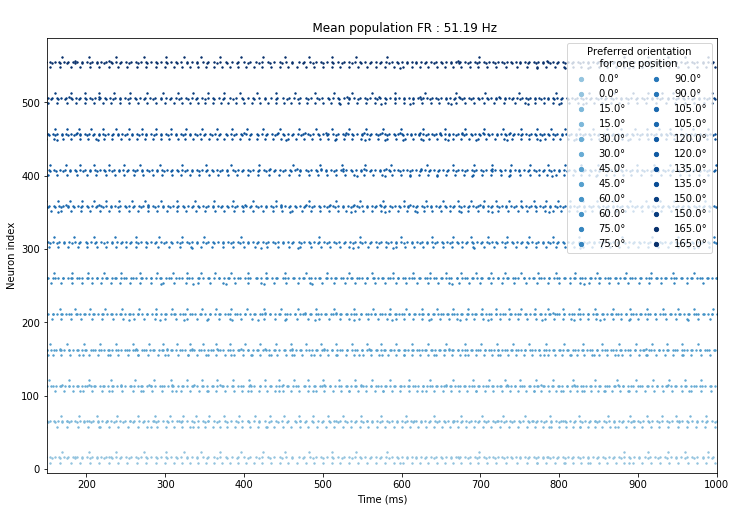

In [23]:
fig, ax = plt.subplots(figsize=(12, 8))
colors = plt.cm.Blues(np.linspace(.4, 1, 12))

neuron_iterator = 0
total_spikes, total_spiking_neurons = 0, 0

for i,orientations in enumerate(test_arr):
    for positions in orientations:
        ax.scatter(v1_data.spiketrains[neuron_iterator],
                   np.full_like(v1_data.spiketrains[neuron_iterator], neuron_iterator),
                   s=2, color=colors[i],
                   label='%.1f°' % (i*(np.pi/12)*180/np.pi) if neuron_iterator%25 ==0 else '')
        
        total_spikes += len(v1_data.spiketrains[neuron_iterator])
        if len(v1_data.spiketrains[neuron_iterator]) > 0:
            total_spiking_neurons += 1
        neuron_iterator += 1

plt.ylim(-5, total_neurons)
plt.xlim(150, total_time)

plt.ylabel('Neuron index')
plt.xlabel('Time (ms)')
handles, labels = ax.get_legend_handles_labels()
#handles[::-1], labels[::-1],
plt.legend(markerscale=3, title='Preferred orientation\n    for one position',
           ncol=2)

plt.title('''
            Mean population FR : %.2f Hz''' % (total_spikes/total_spiking_neurons))

#plt.savefig('./figs/2018_11_16_Ring_spikes_nosynapses_orientation.pdf', format = 'pdf', dpi = 200, bbox_inches = 'tight')
plt.show()

In [24]:
# todo increase gain, i've likely created a highpass filter